In [33]:
#%reload_ext signature
%matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

AttributeError: module 'plotly.graph_objs' has no attribute 'FigureWidget'

In [ ]:
g

In [24]:
data_path = "/home/andreas/Desktop/scientific_computing_project/scans/dicom_scans/01_PE2I_klinik_hermes_SUVr-1/"
output_path = working_path = "/home/andreas/jupyternotebook/scientific_computing_project/output/"
g = glob(data_path + '/*.dcm')

# Print out the first 5 file names to verify we're in the right folder.
print(("Total of %d DICOM images.\nFirst 5 filenames:" % len(g)))
print('\n'.join(g[:5]))



#      
# Loop over the image files and store everything into a list.
# 

def load_scan2(path):
    lstFilesDCM = []  # create an empty list
    for dirName, subdirList, fileList in os.walk(path):
        for filename in fileList:
            if ".dcm" in filename.lower():  # check whether the file's DICOM
                lstFilesDCM.append(os.path.join(dirName,filename))
                
    #Returns sorted list of the DICOM images
    return lstFilesDCM.sort()

def load_scan(path, g):
    slices = [pydicom.read_file(g[s]) for s in range(np.size(g))]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=0
patient = load_scan(data_path, g)
imgs = get_pixels_hu(patient)

Total of 128 DICOM images.
First 5 filenames:
/home/andreas/Desktop/scientific_computing_project/scans/dicom_scans/01_PE2I_klinik_hermes_SUVr-1/ima0052.dcm
/home/andreas/Desktop/scientific_computing_project/scans/dicom_scans/01_PE2I_klinik_hermes_SUVr-1/ima0073.dcm
/home/andreas/Desktop/scientific_computing_project/scans/dicom_scans/01_PE2I_klinik_hermes_SUVr-1/ima0024.dcm
/home/andreas/Desktop/scientific_computing_project/scans/dicom_scans/01_PE2I_klinik_hermes_SUVr-1/ima0037.dcm
/home/andreas/Desktop/scientific_computing_project/scans/dicom_scans/01_PE2I_klinik_hermes_SUVr-1/ima0097.dcm


In [ ]:
patient

In [25]:
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

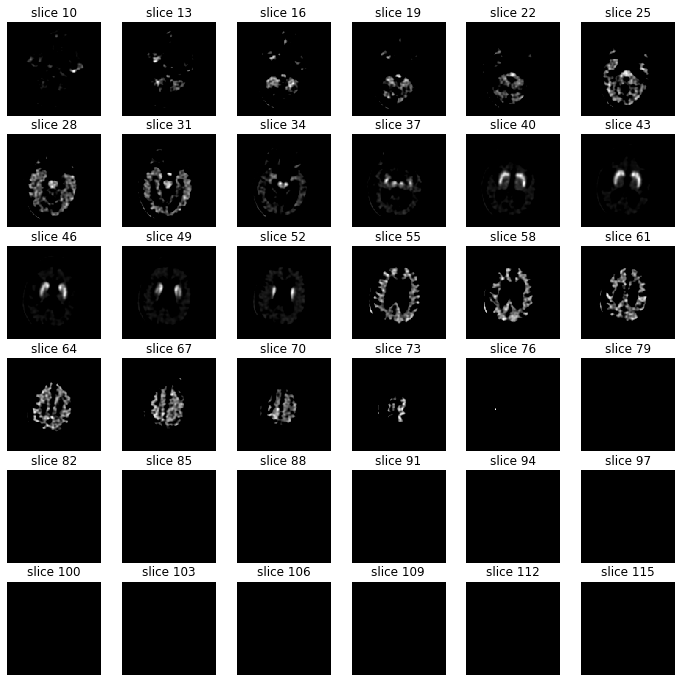

In [26]:
#Display image stack
id = 0
imgs_to_process = np.load(output_path + 'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

In [27]:
np.shape(imgs_to_process)

(128, 128, 128)

In [28]:
print("Slice Thickness: %f" % patient[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    #spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    #spacing = np.array(list(spacing))
    spacing = np.array([1.95, 1.95, 1.95])

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print("Shape after resampling\t", imgs_after_resamp.shape)

Slice Thickness: 1.950000
Pixel Spacing (row, col): (1.950000, 1.950000) 
Shape before resampling	 (128, 128, 128)
Shape after resampling	 (250, 250, 250)


In [29]:
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=0.3)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_facecolor((0.7, 0.7, 0.7))
    plt.show()

Transposing surface
Calculating surface
Drawing


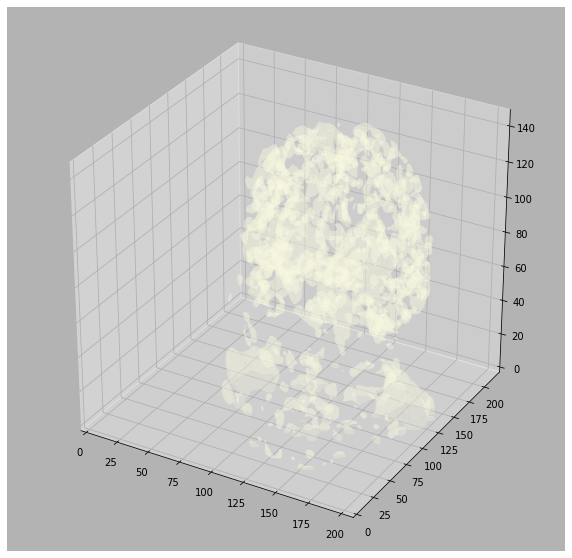

In [30]:
#Disable interactions
%matplotlib inline
v, f = make_mesh(imgs_after_resamp, 350)
plt_3d(v, f)

In [31]:
v, f = make_mesh(imgs_after_resamp, 350, 2)
plotly_3d(v, f)

Transposing surface
Calculating surface
Drawing


/home/andreas/.local/lib/python3.6/site-packages/plotly/tools.py:592: UserWarning:

plotly.tools.FigureFactory.create_trisurf is deprecated. Use plotly.figure_factory.create_trisurf



AttributeError: module 'plotly.graph_objs' has no attribute 'FigureWidget'